# Twitter Sentiment Analysis
**Author:** Christopher Varghese

## Overview

## Business Problem

## Data Understanding
This data was obtained from data.world. It consists of 9,000 tweets that were labeled as positive, negative, or neutral, by real users. Each tweet has three associated columns: the actual tweet, the topic of the tweet, and the determined emotion.

In [56]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# NLP Imports
import nltk
from nltk import FreqDist, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

In [3]:
# Loading in Data
df = pd.read_csv('tweet-collection.csv', encoding = 'latin')

In [4]:
# First Look
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

### Preparation and Cleaning of Data
At this time, the 'emotion_in_tweet_is_directed_at' column is not useful to me since these tweets will not be grouped into those topics. After dropping this column, I will clean up the 'tweet_text' column by removing the user handles, punctuation, and lowercasing. I will also make the column names easier to work with. After this, each tweet should be ready for tokenization and word-vectorization. Any rows with null values will be dropped

In [6]:
# fixing the columns
df1 = df[['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product']]
df1.columns = ['tweet', 'sentiment']

In [7]:
# drop null values
df2 = df1.dropna()

In [8]:
# function for preparing each tweet
# sample = '@thisdude12 told @fiend13 to hang out with 2 cool dudes?? @ like @manequin, and @many6453'

def remove_handles(text):
    pattern = '@[A-Za-z0-9]*'
    replacement = ''
    newstr = re.sub(pattern, replacement, text)
    return newstr

In [51]:
# simplify target

target_labels = ['negative', 'positive', 'neutral', 'unknown']

def simplify_target(text):
    if (text.lower() == 'negative emotion'):
        return 0
    if (text.lower() == 'positive emotion'):
        return 1
    if (text.lower() =='no emotion toward brand or product'):
        return 2
    if (text.lower() == 'i can\'t tell'):
        return 3

In [38]:
# remove punctuation

def remove_punctuation_and_stopwords(text):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens_raw = nltk.regexp_tokenize(text, pattern)
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    tokens_clean = [x.lower() for x in tokens_raw if x.lower() not in stopwords_list]
    return TreebankWordDetokenizer().detokenize(tokens_clean)

In [39]:
# this function will return a sentence with each word lemmatized

lemmatizer = WordNetLemmatizer()

def lemmatize_all(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    new_tokens = list()
    for tup in tagged:
        new_tokens.append(lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])))
    new_tokens
    return TreebankWordDetokenizer().detokenize(new_tokens)

In [40]:
# This is a helper function for lemmatize_all. It takes the POS of each word and finds the appropriate tag
# so that the lemmatization is as accurate as possible.

def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN

In [41]:
# applying functions on columns
df3 = df2.copy()
df3['tweet'] = df2['tweet'].apply(remove_handles)
df4 = df3.copy()
df4['tweet'] = df3['tweet'].apply(remove_punctuation_and_stopwords)
df5 = df4.copy()
df5['tweet'] = df4['tweet'].apply(lemmatize_all)
df5['sentiment'] = df4['sentiment'].apply(simplify_target)

In [42]:
# Before
df2.head(10)

,tweet,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw ...,Positive emotion


In [43]:
# After.. look at that glow up!
df5.head(10)

,tweet,sentiment
0,g iphone hr tweet rise austin dead need upgrad...,0
1,know awesome ipad iphone app likely appreciate...,1
2,wait ipad also sale sxsw,1
3,hope year's festival crashy year's iphone app ...,0
4,great stuff fri sxsw marissa mayer google tim ...,1
5,new ipad apps speechtherapy communication show...,2
7,sxsw start ctia around corner googleio hop ski...,1
8,beautifully smart simple idea rt write hollerg...,1
9,count day sxsw plus strong canadian dollar mea...,1
10,excited meet sxsw show sprint galaxy still run...,1


## Further Analysis
These tweets have been stripped of all handles and punctuation, turned lowercase, and have been lemmatized. After some brief analysis, we will be able to convert this into a sparse matrix and begin modelling. First, I want to examine the distribution of positive, negative, neutral, and inconsclusive tweets. Then, I want to examine the most frequent words that appear throughout the corpus.

In [44]:
# total number of tweets: 9092
df5.shape

(9092, 2)

In [45]:
# percentages of all the tweets
df5['sentiment'].value_counts(normalize = True)

2    0.592609
1    0.327541
0    0.062692
3    0.017158
Name: sentiment, dtype: float64

In [46]:
# percentages of different target classifications
positive = df5['sentiment'].value_counts(normalize = True)[1] * 100
neutral = df5['sentiment'].value_counts(normalize = True)[0] * 100
negative = df5['sentiment'].value_counts(normalize = True)[2] * 100
unknown = df5['sentiment'].value_counts(normalize = True)[3] * 100

In [47]:
# percentage of only positive and negative target classification5
positive_adj = df5['sentiment'].value_counts()[1]
negative_adj = df5['sentiment'].value_counts()[2]
total_pos_and_neg = positive_adj + negative_adj
positive_adj = (positive_adj / total_pos_and_neg) * 100
negative_adj = (negative_adj / total_pos_and_neg) * 100

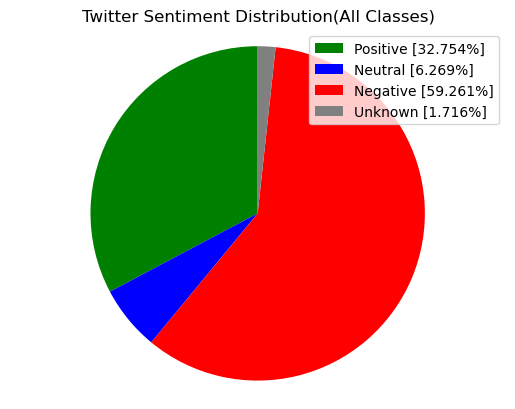

In [50]:
# pi chart of different target classifications
labels = ['Positive ['+str(round(positive, 3))+'%]', 
         'Neutral ['+str(round(neutral, 3))+'%]', 
         'Negative ['+str(round(negative, 3))+'%]',
         'Unknown ['+str(round(unknown, 3))+'%]']
sizes = [positive, neutral, negative, unknown]
colors = ['green', 'blue', 'red', 'grey']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Twitter Sentiment Distribution(All Classes)' )
plt.axis('equal')
plt.show()

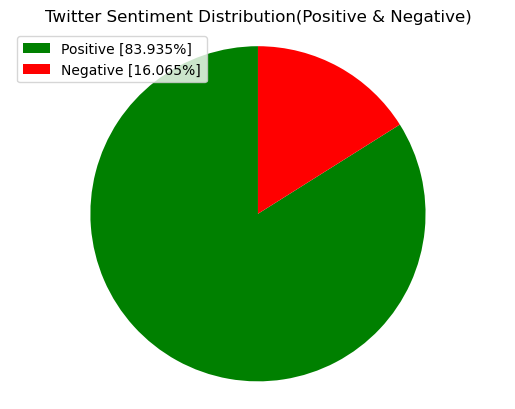

In [20]:
# pi chart of only positive and negative target classifications
labels = ['Positive ['+str(round(positive_adj, 3))+'%]', 'Negative ['+str(round(negative_adj, 3))+'%]']
sizes = [positive, negative]
colors = ['green', 'red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Twitter Sentiment Distribution(Positive & Negative)' )
plt.axis('equal')
plt.show()

In [24]:
# Examining the frequency distribution.. First, we must compile all the words into a single list.
tweet_tokens = list()
for tweet in df5['tweet']:
    tweet_tokens += nltk.word_tokenize(tweet)
len(tweet_tokens)

106471

In [28]:
# Set of all vocab used in these tweets
tweet_word_set = set()
for tweet in df5['tweet']:
    tweet_word_set.update(nltk.word_tokenize(tweet))
len(tweet_word_set)

7796

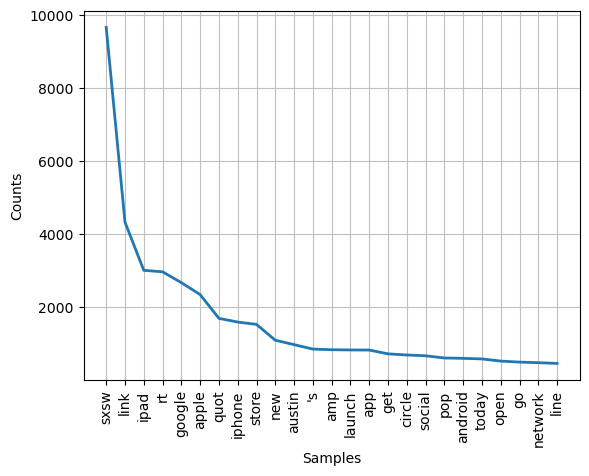

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [32]:
# The 9,092 tweets are comprised of 106,471 words after cleaning. suprisingly, there are only 7,796 unique words.
# Let's take a look at the frequency distribution of the most common words.
tweet_dist = nltk.FreqDist(tweet_tokens)
tweet_dist.plot(25, cumulative = False)

### Last Thoughts on Data
The distribution of the raw data set shows that the vast majority of tweets are neutral with only a third being positive and less than 10% being positive. It may be necessary to develop the model as a binary classification and then develop it into a multiclassifcation. Due to the overwhelming amount of 'neutral' tweets, it is actually very important for a model to be able to pick out the neutral tweets. This will insure that only the tweets that have a sentiment are being utilized for whatever task at hand. The frequency distribution shows that there are many words that overlap. Even though there are only approx. 9k tweets, the top 10 most common words are appear more than 1k times. The most common tag, sxsw, is actually a hashtag that denotes a particular confrence that most of these tweets are centered around. I will tweak the model by expirementing with removing one or more of the most common words.

## Modelling
For my models I plan to use

In [57]:
## Train Test Split
X_train, y_train, X_test, y_test = train_test_split(df5['tweet'], df5['sentiment'], random_state = 42)

### TF-IDF
Tweets are short bits of information. I think a bag of words approach will be effective in modelling the sentiment associated with each tweet. 

In [52]:
data = list(df5['tweet'])
target = list(df5['sentiment'])
target_labels

['negative', 'positive', 'neutral', 'unknown']

In [ ]:
vectorizer = TfidfVectorizer()
tf_idf_data_train = vectorizer.fit_transform(data)


### Tokenization

## Conclusion and Next Steps